## Projeto Lógico


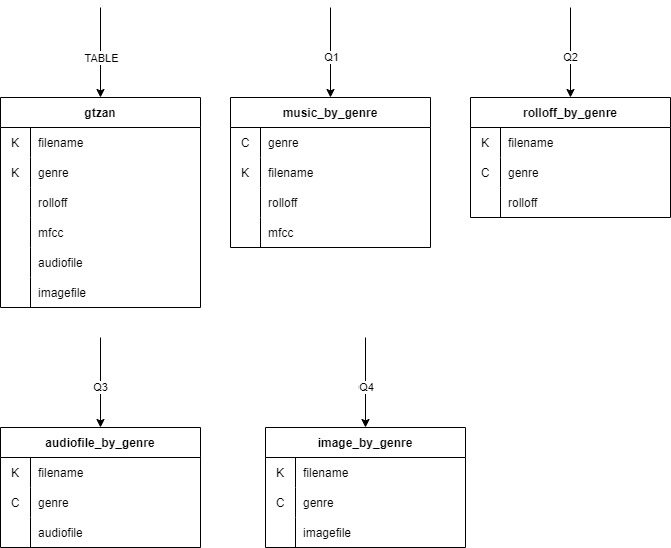

In [2]:
from IPython.display import Image
Image("Images/logico_cassandra.jpg")

## Preparando dataframe para inserir no banco de dados


In [1]:
import pandas as pd

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
data30s = pd.read_csv("Data/features_30_sec.csv")
data3s = pd.read_csv("Data/features_3_sec.csv")

In [2]:
import os
from bson.binary import Binary

root_music_dir = 'Data\genres_original'
root_image_dir = 'Data\images_original'

def find_music(genre, filename):
        # Função para pegar o arquivo .wav com o filename e retornar ele escrito em binário 
	genre_dir = os.path.join(root_music_dir, genre)
	audio_path = os.path.join(genre_dir, filename)
	try:
		with open(audio_path, 'rb') as f:
			encoded_audio = f.read()
	except:
		encoded_audio = None
   
	return encoded_audio

def find_image(genre, filename):
        # Função para pegar o arquivo .png com o filename e retornar ele escrito em binário 
	genre_dir = os.path.join(root_image_dir, genre)
	audio_path = os.path.join(genre_dir, filename[:-10]+filename[-9:-4]+'.png')
  
	try:
		with open(audio_path, 'rb') as f:
			encoded_image = Binary(f.read())
	except:
		encoded_image = None
	return encoded_image

In [3]:
data = []
for genre in genres:
	print("Processando: " + genre)
	query = "label == '" + genre + "'"
	conj30s = data30s.query(query)
	conj3s = data3s.query(query)
	for index, row in conj30s.iterrows():
		filename = row["filename"]
		rolloff = row["rolloff_mean"]
		mfcc = []
  
		segments = conj3s[conj3s['filename'].str.contains(row["filename"][:-4])]
  
		for index_seg, row_seg in segments.iterrows():
			for i in range(1,21):
				mfcc_mean = "mfcc" + str(i) + "_mean"
				mfcc.append(row_seg[mfcc_mean])
    
		data.append([filename,genre,rolloff,mfcc,find_music(genre, filename),find_image(genre, filename)])

Processando: blues
Processando: classical
Processando: country
Processando: disco
Processando: hiphop
Processando: jazz
Processando: metal
Processando: pop
Processando: reggae
Processando: rock


In [4]:
df = pd.DataFrame(data, columns=['filename','genre', 'rolloff', 'mfcc', 'audiofile', 'imagefile'])
df.head()

,filename,genre,rolloff,mfcc,audiofile,imagefile
0,blues.00000.wav,blues,3805.839606,"[-118.62791442871094, 125.08362579345705, -23....",b'RIFFh2\x14\x00WAVEfmt \x10\x00\x00\x00\x01\x...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,blues.00001.wav,blues,3550.522098,"[-266.1217956542969, 116.85723876953124, 17.07...",b'RIFFh2\x14\x00WAVEfmt \x10\x00\x00\x00\x01\x...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,blues.00002.wav,blues,3042.260232,"[-114.2937240600586, 129.3975372314453, -25.80...",b'RIFFh2\x14\x00WAVEfmt \x10\x00\x00\x00\x01\x...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3,blues.00003.wav,blues,2184.745799,"[-227.83001708984372, 157.87364196777344, 5.62...",b'RIFFh2\x14\x00WAVEfmt \x10\x00\x00\x00\x01\x...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4,blues.00004.wav,blues,3579.757627,"[-180.588134765625, 148.95291137695312, -42.00...",b'RIFFh2\x14\x00WAVEfmt \x10\x00\x00\x00\x01\x...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


## Criando um keyspace e a tabela


In [1]:
from cassandra.cluster import Cluster
cluster = Cluster(['127.0.0.1'],port='9042') 
session = cluster.connect()

In [ ]:
try:
    session.execute("""
        CREATE KEYSPACE bdcd 
        WITH replication = { 'class': 'SimpleStrategy', 'replication_factor': '1' }
    """)
except Exception as e:
    print(e)

In [8]:
session.set_keyspace('bdcd')

In [14]:
try:
    session.execute("""
        CREATE TABLE gtzan (
            filename text,
            genre text,
            mfcc list<float>,
            rolloff float,
            audiofile blob,
            imagefile blob,
            PRIMARY KEY (filename, genre)
        )
    """)
except Exception as e:
    print(e)

## Inserindo no banco de dados


In [18]:
query = session.prepare("""
    INSERT INTO gtzan (filename, genre, mfcc, rolloff, audiofile, imagefile)
    VALUES (?, ?, ?, ?, ?, ?)
""")


for i in df.index:
    try:
        session.execute(query, (df['filename'][i], df['genre'][i], df['mfcc'][i],
                                 df['rolloff'][i], df['audiofile'][i], df['imagefile'][i]))
    except Exception as e:
        print(e)

In [20]:
rows = session.execute("SELECT filename, genre FROM gtzan")
print("Total: {}\n".format(len(rows.current_rows)))
for row in rows[:20]:
    print("{:<20} | {:<15}".format(row.filename, row.genre))

Total: 1000

jazz.00062.wav       | jazz           
metal.00018.wav      | metal          
pop.00072.wav        | pop            
pop.00005.wav        | pop            
country.00033.wav    | country        
hiphop.00096.wav     | hiphop         
disco.00055.wav      | disco          
country.00013.wav    | country        
pop.00013.wav        | pop            
metal.00022.wav      | metal          
pop.00017.wav        | pop            
jazz.00093.wav       | jazz           
jazz.00022.wav       | jazz           
rock.00091.wav       | rock           
rock.00044.wav       | rock           
country.00010.wav    | country        
disco.00033.wav      | disco          
jazz.00048.wav       | jazz           
classical.00049.wav  | classical      
pop.00065.wav        | pop            


## Views e consultas


### Retornar músicas


In [2]:
query = """
	CREATE MATERIALIZED VIEW bdcd.music_by_genre
	AS SELECT filename, genre, mfcc, rolloff FROM bdcd.gtzan
	WHERE genre IS NOT NULL AND
	filename IS NOT NULL 
	PRIMARY KEY (genre, filename)
"""
session.execute(query)

AlreadyExists: Table 'bdcd.music_by_genre' already exists

In [18]:
rows = session.execute("SELECT * FROM bdcd.music_by_genre")

last_genre = ""
for row in rows:
        if row.genre != last_genre:
                mfcc_str = ', '.join([str(elem) for elem in row.mfcc])
                print("{:<15} | {:<20} | {:<18} | {:<10}".format(row.genre, row.filename, row.rolloff, mfcc_str))
                last_genre = row.genre


classical       | classical.00000.wav  | 2716.30615234375   | -260.67340087890625, 133.82301330566406, -36.128211975097656, 36.49444580078125, -11.123296737670898, 29.24653434753418, -18.622739791870117, 8.853854179382324, -11.809219360351562, 25.13092041015625, -1.943104863166809, 12.997270584106445, -20.94135284423828, -10.465611457824707, -1.5277247428894043, 13.206610679626465, -1.666343092918396, 4.525014400482178, -0.8978886604309082, 4.1606292724609375, -283.2200927734375, 139.42539978027344, -49.4188346862793, 21.725046157836914, -20.708696365356445, 21.721424102783203, -15.821676254272461, 6.564035892486572, -16.794145584106445, 12.470782279968262, -4.159862518310547, 13.751847267150879, -3.1211557388305664, 1.934420108795166, 1.4958552122116089, 5.8249053955078125, -1.546097993850708, 7.157280445098877, 2.7185323238372803, -1.692274808883667, -263.8149719238281, 139.13442993164062, -36.79767990112305, 18.733539581298828, -19.788188934326172, 20.89822769165039, -4.583742618560

### Média de rolloff por gênero e música com maior valor


In [5]:
query = """
	CREATE MATERIALIZED VIEW bdcd.rolloff_by_genre
	AS SELECT filename, genre, rolloff FROM bdcd.gtzan
	WHERE genre IS NOT NULL AND
	filename IS NOT NULL 
	PRIMARY KEY (genre, filename)
"""
session.execute(query)


In [17]:
query = """
    SELECT genre, AVG(rolloff) as avg_rolloff FROM bdcd.rolloff_by_genre
    GROUP BY genre
"""
rows = session.execute(query)
for row in rows:
    print("{:15} | {:20}".format(row.genre, row.avg_rolloff))

classical       |    2482.325927734375
reggae          |       4593.939453125
rock            |     4669.18017578125
metal           |        5125.23046875
pop             |     6654.77294921875
blues           |    3636.877197265625
disco           |      5519.7919921875
country         |      3949.5771484375
jazz            |     3750.17431640625
hiphop          |      5333.6240234375


In [9]:
query = """
    SELECT filename, rolloff FROM bdcd.rolloff_by_genre
"""
rows = session.execute(query)

rows_list = list(rows)

rows_list.sort(key=lambda row: row.rolloff, reverse=True)

print(rows_list[0].filename)


pop.00051.wav


### Arquivos de áudio


In [8]:
import os

def deletar_arquivos(pasta):
    for nome_arquivo in os.listdir(pasta):
        caminho_arquivo = os.path.join(pasta, nome_arquivo)
        if os.path.isfile(caminho_arquivo):
            os.remove(caminho_arquivo)

In [10]:
query = """
	CREATE MATERIALIZED VIEW bdcd.audiofile_by_genre
	AS SELECT filename, genre, audiofile FROM bdcd.gtzan
	WHERE genre IS NOT NULL AND
	filename IS NOT NULL AND
	audiofile IS NOT NULL
	PRIMARY KEY (genre, filename)
"""
session.execute(query)


In [16]:
query = "SELECT * FROM bdcd.audiofile_by_genre WHERE filename = 'blues.00083.wav'  ALLOW FILTERING"
rows = session.execute(query)

for row in rows:
        filename = row.filename
        with open("Data/retrieved_data/audio/"+filename,"wb") as f:
            f.write(row.audiofile)

In [15]:
deletar_arquivos('Data/retrieved_data/audio/')

### Arquivos de imagem


In [14]:
query = """
	CREATE MATERIALIZED VIEW bdcd.imagefile_by_genre
	AS SELECT filename, genre, imagefile FROM bdcd.gtzan
	WHERE genre IS NOT NULL AND
	filename IS NOT NULL AND
	imagefile IS NOT NULL
	PRIMARY KEY (genre, filename)
"""
session.execute(query)


In [15]:
query = "SELECT * FROM bdcd.imagefile_by_genre WHERE genre = 'blues'"
rows = session.execute(query)

for row in rows:
        filename = row.filename
        with open("Data/retrieved_data/image/"+filename[:-3]+'png',"wb") as f:
            f.write(row.imagefile)

In [16]:
deletar_arquivos('Data/retrieved_data/image/')

### Similaridade entre músicas


#### Similaridade por coeficiente de pearson


In [3]:
query = """
	CREATE MATERIALIZED VIEW bdcd.mfcc_by_genre
	AS SELECT filename, genre, mfcc FROM bdcd.gtzan
	WHERE genre IS NOT NULL AND
	filename IS NOT NULL 
	PRIMARY KEY (genre, filename)
"""
session.execute(query)

In [19]:
from scipy.stats import pearsonr
import pandas as pd

def achar_similaridade(genre, filename):
        genre = str(genre)
        filename = str(filename)
        
        filename_similar = []
        correlation = []
        
        query = "SELECT * FROM bdcd.mfcc_by_genre WHERE genre = '"+genre+"'AND filename='"+filename+"'"
        rows = session.execute(query)
	
        if len(rows.current_rows) == 0:
                return None
        
        mfcc1 = rows.one().mfcc


        query = "SELECT * FROM bdcd.mfcc_by_genre WHERE  genre = '"+genre+"'"
        rows = session.execute(query)
        
        if len(rows.current_rows) == 0:
                return None
        
        for row in rows:
                fn = row.filename
                if fn != filename:
                        mfcc2 = row.mfcc
                        
                        if len(mfcc1) != len(mfcc2):
                                
                                if len(mfcc1) > len(mfcc2):
                                        corr, _ = pearsonr(mfcc1[:len(mfcc2)], mfcc2)
                                else:
                                        corr, _ = pearsonr(mfcc1, mfcc2[:len(mfcc1)])

                                if corr > 0.95:
                                                filename_similar.append(fn)
                                                correlation.append(corr)
                        else:
                                corr, _ = pearsonr(mfcc1, mfcc2)

                                if corr > 0.95:
                                        filename_similar.append(fn)
                                        correlation.append(corr)
                                        
                        dataframe = {
                                'similar_com': filename_similar,
                                'indice': correlation
                        }                        

        df = pd.DataFrame(dataframe)
        return df

df = achar_similaridade('rock','rock.00010.wav').sort_values('indice', ascending=False)
df.head()

SELECT * FROM bdcd.mfcc_by_genre WHERE genre = 'rock'AND filename='rock.00010.wav'


,similar_com,indice
2,rock.00004.wav,0.982108
18,rock.00083.wav,0.981269
14,rock.00077.wav,0.980788
15,rock.00078.wav,0.978736
10,rock.00072.wav,0.978344


#### Similaridade por cross-similarity


In [24]:
import librosa
import matplotlib.pyplot as plt


def cross_similarity(filename1, filename2, genre):
        try:
                query_genre = " AND genre = '"+genre+"'"
                query = "SELECT * FROM bdcd.audiofile_by_genre WHERE filename = '"+filename1+"'"
                query += query_genre
                rows = session.execute(query)
                
                music1 = rows.one()

                query = "SELECT * FROM bdcd.audiofile_by_genre WHERE filename = '"+filename2+"'"
                query += query_genre
                rows = session.execute(query)
                
                music2 = rows.one()
                
                file1 = music1.audiofile
                file2 = music2.audiofile
                if file1 and file2:
                        with open('Data/retrieved_data/audio/'+filename1,'wb') as f:
                                f.write(file1)
                        with open('Data/retrieved_data/audio/'+filename2,'wb') as f:
                                f.write(file2)
                else:
                        raise FileNotFoundError
        except FileNotFoundError:
                print('Arquivo '+filename1+' ou '+ filename2 +' não encontrado')
                deletar_arquivos('Data/retrieved_data/audio/')
        
        y1, sr1 = librosa.load('Data/retrieved_data/audio/'+filename1)
        y2, sr2 = librosa.load('Data/retrieved_data/audio/'+filename2)
        
        deletar_arquivos('Data/retrieved_data/audio/')
        
        mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1)
        mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2)

        x_sim = librosa.segment.cross_similarity(mfcc1, mfcc2, metric='cosine', mode='affinity')

        fig, ax = plt.subplots()
        img = librosa.display.specshow(x_sim, x_axis='time', y_axis='time', ax=ax, cmap='magma_r')
        ax.set(title='Similaridade Cruzada')
        fig.colorbar(img, ax=ax)
        plt.show() 

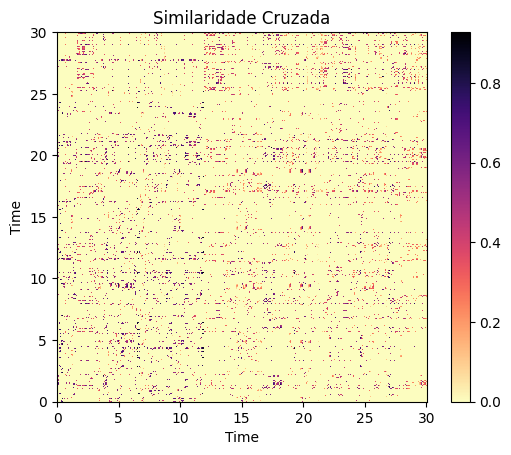

In [26]:
filename1 = 'pop.00019.wav'
filename2 = 'pop.00015.wav'

cross_similarity(filename1,filename2,'pop')

### Fechando conexão


In [27]:
cluster.shutdown()
